# Deteksi Stunting

## Import Library

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.preprocessing import label_binarize

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn import tree

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import roc_curve, auc
from itertools import cycle

import warnings

import pickle

In [16]:
# Suppress FitFailedWarning
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

### Load Dataframe

In [17]:
df = pd.read_csv('/home/rmfarizky/Project/deteksi_stunting/Deteksi_Stunting/Classification/data_17-1.csv')
# df = pd.read_csv('/home/rmfarizky/Project/deteksi_stunting/DRAFT/Dataset/new_draft/final_data.csv')


In [18]:
df.head()

,JK,Usia Saat Ukur,Berat,Tinggi,LiLA,ZS BB/U,ZS TB/U,ZS BB/TB,BB/U,TB/U,BB/TB
0,1,3,5.0,55.0,0.0,-2.24,-3.42,1.09,1,0,3
1,1,37,10.0,85.4,14.4,-3.20,-3.19,-2.06,0,0,1
2,1,51,11.1,91.7,13.6,-3.40,-3.29,-2.31,0,0,1
3,1,29,8.2,78.2,13.5,-4.06,-4.12,-2.79,0,0,1
4,1,28,8.4,77.9,16.6,-3.83,-4.32,-2.24,0,0,1


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2836 entries, 0 to 2835
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   JK              2836 non-null   int64  
 1   Usia Saat Ukur  2836 non-null   int64  
 2   Berat           2836 non-null   float64
 3   Tinggi          2836 non-null   float64
 4   LiLA            2836 non-null   float64
 5   ZS BB/U         2836 non-null   float64
 6   ZS TB/U         2836 non-null   float64
 7   ZS BB/TB        2836 non-null   float64
 8   BB/U            2836 non-null   int64  
 9   TB/U            2836 non-null   int64  
 10  BB/TB           2836 non-null   int64  
dtypes: float64(6), int64(5)
memory usage: 243.8 KB


In [20]:
def visualize_data (x):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    x.iloc[:,-3].value_counts().plot.bar(color='coral', ax=axs[0])
    axs[0].set_title('BB/U Distribution')
    axs[0].set_yticks(range(0, max(x.iloc[:, -3].value_counts()) + 1, 100))

    x.iloc[:,-2].value_counts().plot.bar(color='coral', ax=axs[1])
    axs[1].set_title('TB/U Distribution')
    axs[1].set_yticks(range(0, max(x.iloc[:, -2].value_counts()) + 1, 100))

    x.iloc[:,-1].value_counts().plot.bar(color='coral', ax=axs[2])
    axs[2].set_title('BB/TB Distribution')
    axs[2].set_yticks(range(0, max(x.iloc[:, -1].value_counts()) + 1, 100))

In [21]:
def visualize_distribution_pie(x):
    
    
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    palette = sns.color_palette('pastel')

    # Visualisasi untuk BB/U
    bbu_counts = x.iloc[:,-3].value_counts()
    axs[0].pie(bbu_counts, labels=bbu_counts.index, autopct='%1.1f%%', colors=palette)
    axs[0].set_title('BB/U Distribution')

    # Visualisasi untuk TB/U
    tbu_counts = x.iloc[:,-2].value_counts()
    axs[1].pie(tbu_counts, labels=tbu_counts.index, autopct='%1.1f%%', colors=palette)
    axs[1].set_title('TB/U Distribution')

    # Visualisasi untuk BB/TB
    bbtb_counts = x.iloc[:,-1].value_counts()
    axs[2].pie(bbtb_counts, labels=bbtb_counts.index, autopct='%1.1f%%', colors=palette)
    axs[2].set_title('BB/TB Distribution')
    
    plt.suptitle('Perbandingan Data Pada Tiap Target Klasifikasi', fontsize=16)
    plt.show()


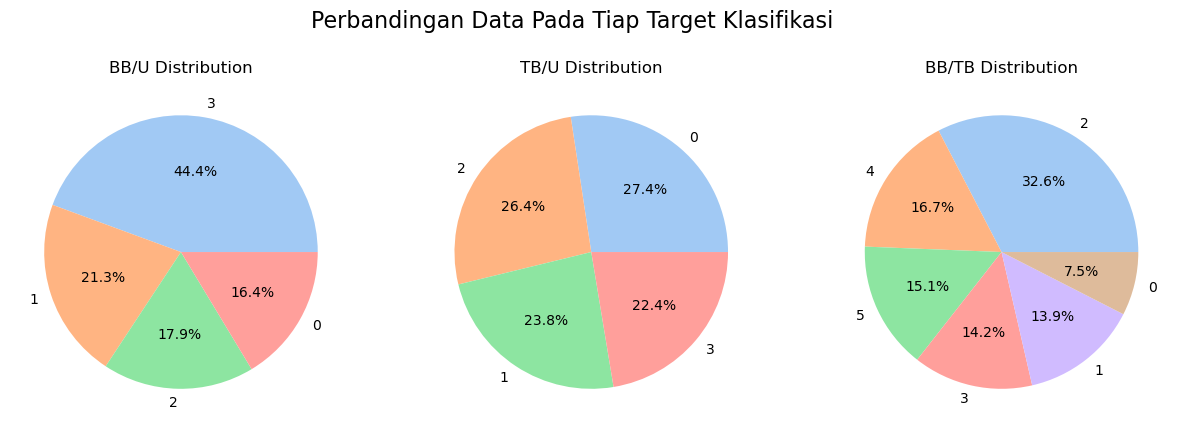

In [22]:
visualize_distribution_pie(df)

### Keterangan Encoding:
- BB/U -> {'Sangat Kurang': 0, 'Kurang': 1, 'Normal': 2, 'Risiko Lebih': 3}
- TB/U -> {'Sangat Pendek': 0, 'Pendek': 1, 'Normal': 2, 'Tinggi': 3}
- BB/TB -> {'Gizi Buruk': 0, 'Gizi Kurang': 1, 'Gizi Baik': 2, 'Risiko Gizi Lebih': 3, 'Gizi Lebih': 4, 'Obesitas': 5}

## Heatmap

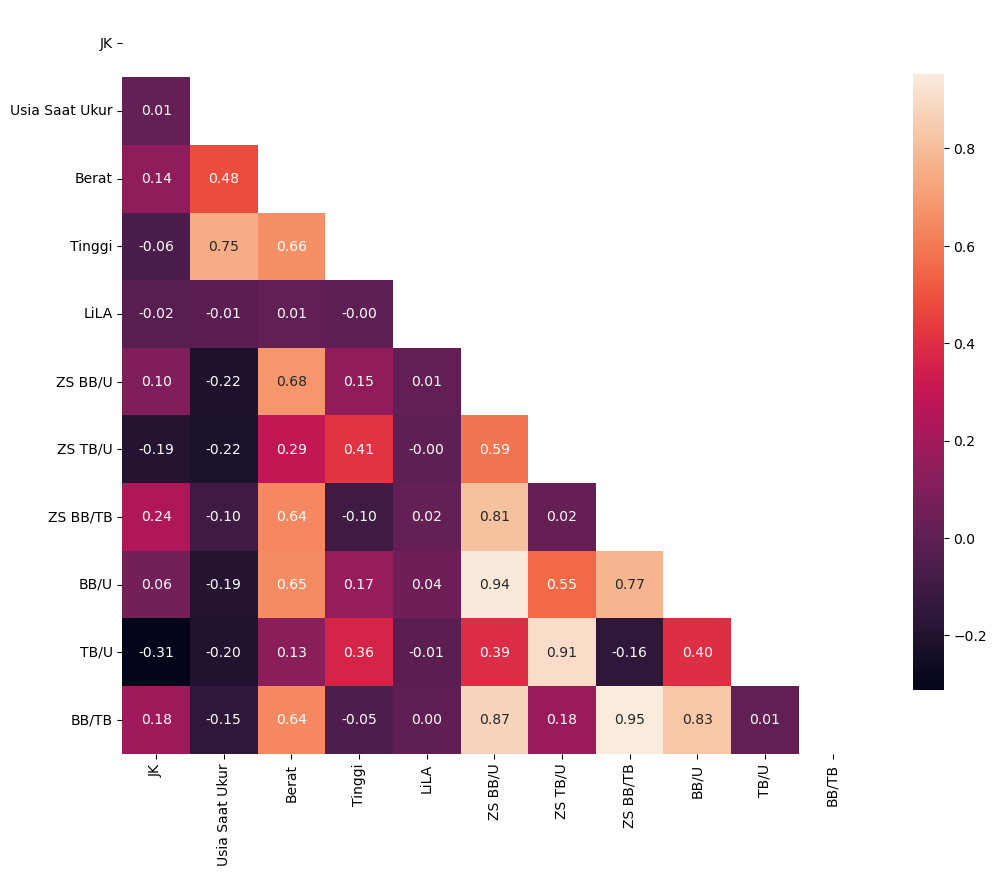

In [23]:
# Create correlation matrix
corr_matrix = df.corr()

# Create a mask
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set the figure size
plt.figure(figsize=(12, 10))

# Create a heatmap
sns.heatmap(corr_matrix,
            annot=True,
            fmt=".2f",  # Format for the annotations
            mask=mask,  # To hide the upper triangle
            cbar_kws={"shrink": 0.8},  # To adjust the colorbar size
            square=True)  # To make the cells square

plt.show()

# Pemisahan dan Pembagian Data

Pemisahan Fitur dan Target

In [24]:
fitur = [
        'JK',
         'Usia Saat Ukur',
         'Berat',
         'Tinggi',
        #'LiLA',
        'ZS BB/U', 
        'ZS TB/U'
        # 'ZS BB/TB'
        ]
# df.columns[:-6]

In [25]:
X = df[fitur]
y = df[df.columns[-3:]]

Pembagian Data Latih dan Data Uji

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,
                                                    stratify=y[y.columns[-1]]
                                                    )

In [27]:
print(X_train.shape, X_test.shape)

(2268, 6) (568, 6)


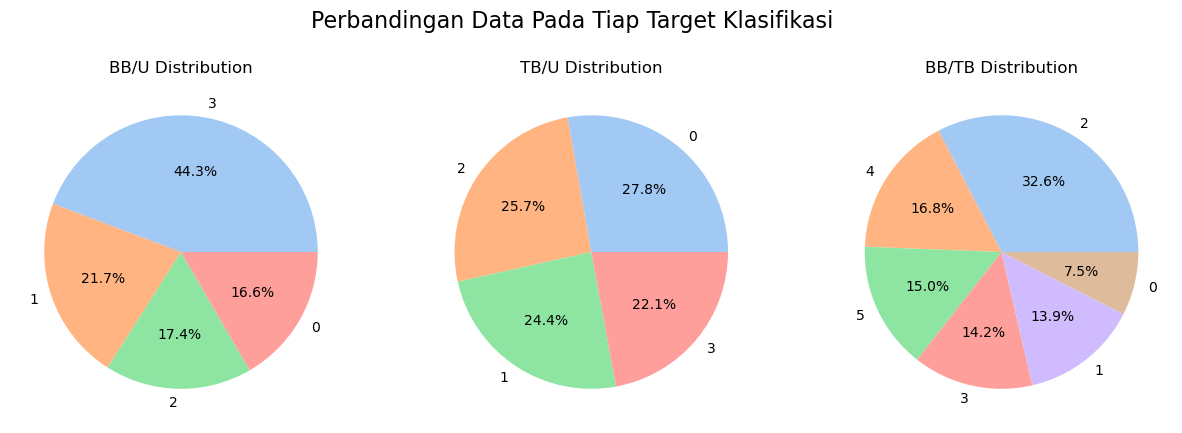

In [28]:
visualize_distribution_pie(y_train)

Global Variabel

In [29]:
targets = ['BB/U', 'TB/U', 'BB/TB']
metode = ['Decision Tree', 'Naive Bayes', 'Raandom Forest']

# Hyper-Tuning Parameter

## Decision Tree

Penyesuaian Parameter

In [30]:
# Define the parameter grid to search
param_grid = {
    'estimator__max_depth': [10, 20, 30],
    'estimator__min_samples_split': [2, 5, 10],
    'estimator__min_samples_leaf': [1, 2, 4],
    'estimator__max_features': ['auto', 'sqrt', 'log2']
}

Parameter Test and Evaluation

In [31]:
# Create a Random Forest classifier
dt_model = DecisionTreeClassifier()

# Multi-output wrapper for Random Forest classifier
multi_output_dt = MultiOutputClassifier(dt_model)

# Grid search with cross-validation
grid_search = GridSearchCV(estimator=multi_output_dt, param_grid=param_grid, cv=5, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best parameters:", best_params)
print("Best cross-validation score:", best_score)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
test_score = best_model.score(X_test, y_test)
print("Test set score of the best model:", test_score)

Best parameters: {'estimator__max_depth': 20, 'estimator__max_features': 'sqrt', 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2}
Best cross-validation score: 0.8769904017271056
Test set score of the best model: 0.8802816901408451


## Random Forest

Global Variable

Penyesuaian Parameter

In [32]:
# Define the parameter grid to search
param_grid = {
    'estimator__n_estimators': [50, 100, 200],  # Number of trees in the forest
    'estimator__max_depth': [10, 20, 30],      # Maximum depth of the trees
    'estimator__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    'estimator__min_samples_leaf': [1, 2, 4],    # Minimum number of samples required at each leaf node
}

Parameter Test and Evaluation

In [33]:
# Create a Random Forest classifier
rf_model = RandomForestClassifier()

# Multi-output wrapper for Random Forest classifier
multi_output_rf = MultiOutputClassifier(rf_model)

# Grid search with cross-validation
grid_search = GridSearchCV(estimator=multi_output_rf, param_grid=param_grid, cv=5, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best parameters:", best_params)
print("Best cross-validation score:", best_score)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
test_score = best_model.score(X_test, y_test)
print("Test set score of the best model:", test_score)

Best parameters: {'estimator__max_depth': 20, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__n_estimators': 200}
Best cross-validation score: 0.9298907916873317
Test set score of the best model: 0.9348591549295775


# Define The Model

## Decision Tree

- Best parameters: {'estimator__max_depth': 30, 'estimator__max_features': 'sqrt', 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2}
- Best cross-validation score: 0.9620727212610983
- Test set score of the best model: 0.9507042253521126

Fix Parameter

In [34]:
DT_Model = DecisionTreeClassifier(max_depth=30,
                                  max_features='sqrt',
                                  min_samples_leaf=1,
                                  min_samples_split=2
            )
start_time = time.time()
DT_model = DT_Model.fit(X_train, y_train)
end_time = time.time()

In [35]:
training_time = end_time - start_time
training_time

0.008746147155761719

In [36]:
DT_model

DecisionTreeClassifier(max_depth=30, max_features='sqrt')

## Naive Bayes

In [37]:
nb_model = GaussianNB() 
NB_Model = MultiOutputClassifier(nb_model, n_jobs=-1)
start_time = time.time()
NB_model = NB_Model.fit(X_train, y_train)
end_time = time.time()

In [38]:
elapsed_time = end_time - start_time
print("Waktu komputasi:", elapsed_time, "detik")

Waktu komputasi: 0.015200138092041016 detik


In [39]:
NB_model

MultiOutputClassifier(estimator=GaussianNB(), n_jobs=-1)

## Random Forest

- Best parameters: {'estimator__bootstrap': True, 'estimator__max_depth': 10, 'estimator__min_samples_leaf': 2, 'estimator__min_samples_split': 2, 'estimator__n_estimators': 50}
- Best cross-validation score: 0.9977963843588024
- Test set score of the best model: 0.9964788732394366

In [40]:
RF_Model = RandomForestClassifier(bootstrap= True,
                                  max_depth= 10,
                                  min_samples_leaf=2,
                                  min_samples_split=2,
                                  n_estimators=50)
start_time = time.time()
RF_model = RF_Model.fit(X_train, y_train)
end_time = time.time()

In [41]:
elapsed_time = end_time - start_time
print("Waktu komputasi:", elapsed_time, "detik")

Waktu komputasi: 0.19140338897705078 detik


In [42]:
RF_model

RandomForestClassifier(max_depth=10, min_samples_leaf=2, n_estimators=50)

# Pengujian dan Evaluasi Model

Memprediksi Data test

In [43]:
DT_ypred = DT_model.predict(X_test).T
RF_ypred = RF_model.predict(X_test).T
NB_ypred = NB_model.predict(X_test).T

Penyeragaman Bentuk Data

In [44]:
arr_X_test = np.array(X_test.T)

In [45]:
arr_y_test = np.array(y_test.T)

## Confusion Matrix

In [46]:
def plot_confusion_matrices(y_prediction, model_name):
    def plot_confusion_matrix(y_prediction, arr_y_test):
        labels = [c for c in range(confusion_matrix(y_prediction, arr_y_test).shape[1])]
        sns.heatmap(confusion_matrix(arr_y_test, y_prediction), annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
        plt.xlabel('True Label')
        plt.ylabel('Predicted Label')
        

    plt.figure(figsize=(24, 5))
    plt.suptitle(f'Confusion Matrix {model_name} Model', fontsize=16)

    for i, y_pred_T in enumerate(y_prediction):
        plt.subplot(1, len(y_prediction), i+1)
        plt.title(f'Confusion Matrix for {targets[i]}')
        plot_confusion_matrix(y_pred_T, arr_y_test[i])
    plt.show()

In [47]:
model_name = ['Decision Tree', 'Naive Bayes', 'Random Forest']

### Decision Tree

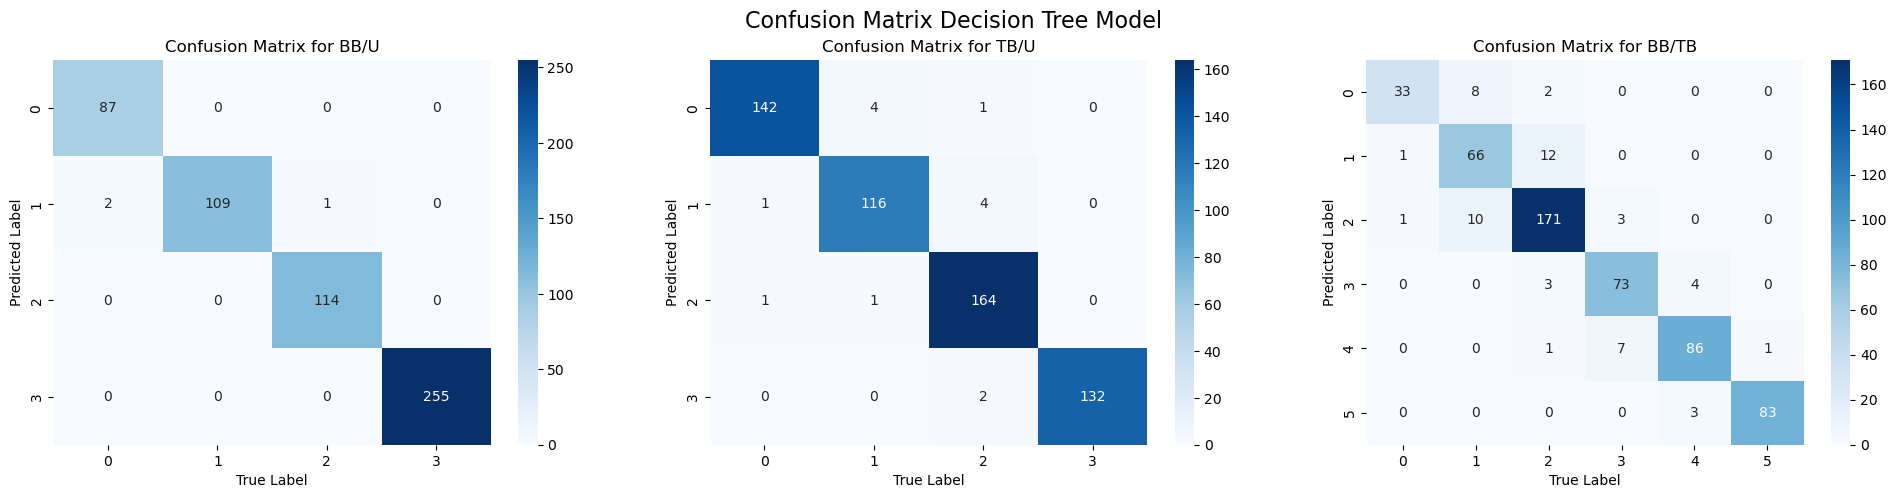

In [48]:
plot_confusion_matrices(DT_ypred, model_name[0])

### Naive Bayes

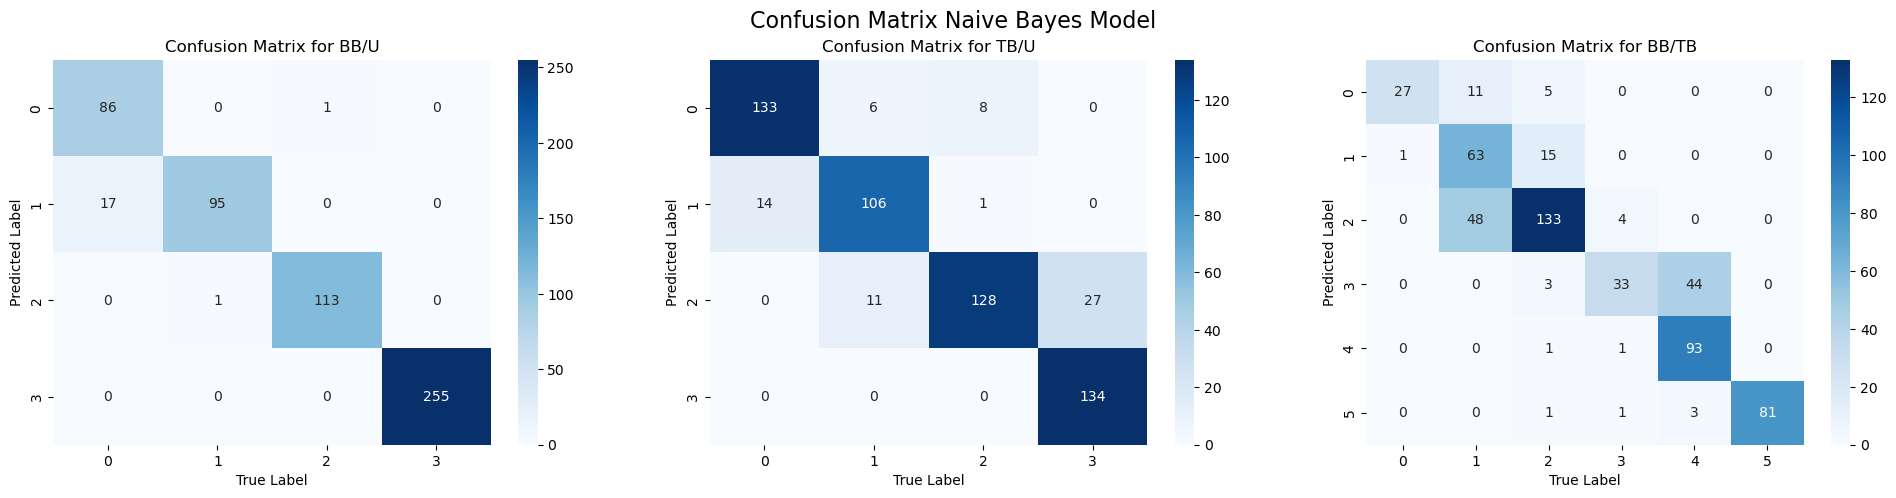

In [49]:
plot_confusion_matrices(NB_ypred, model_name[1])

### Random Forest

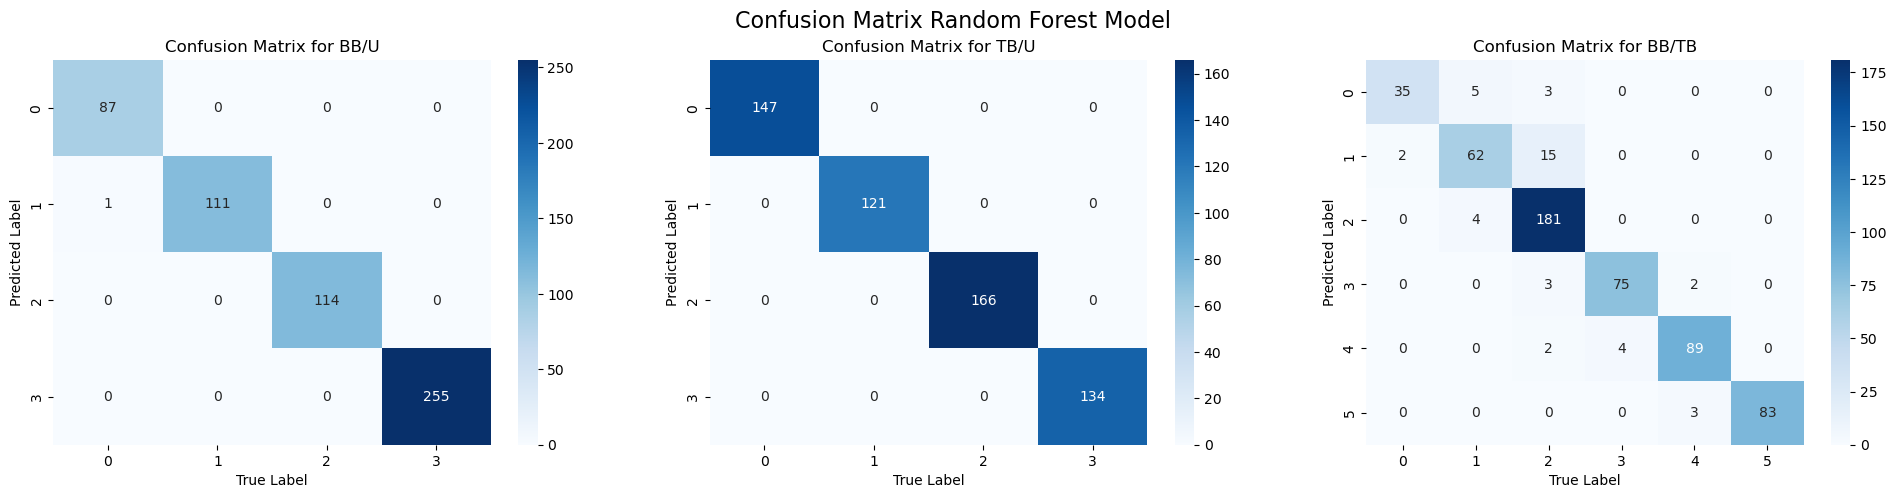

In [50]:
plot_confusion_matrices(RF_ypred, model_name[2])

## Classification Report 

In [51]:
def report_of_class(y_prediction, model_name):
    print(f"Laporan Klasifikasi Model {model_name}")
    # Inisialisasi list untuk menyimpan laporan klasifikasi
    reports = []

    # Iterasi melalui setiap variabel target
    for i in range(y_test.shape[1]):
        # Hitung laporan klasifikasi untuk variabel target ke-i
        report = classification_report(arr_y_test[i], y_prediction[i])
        # Tambahkan laporan klasifikasi ke dalam list
        reports.append(report)

    # Tampilkan laporan klasifikasi untuk setiap variabel target
    for i, report in enumerate(reports):
        print(f"Laporan Klasifikasi untuk Target {targets[i]}:")
        print(report)
        print("\n")  

### Decision Tree

In [52]:
report_of_class(DT_ypred, model_name[0])

Laporan Klasifikasi Model Decision Tree
Laporan Klasifikasi untuk Target BB/U:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        87
           1       1.00      0.97      0.99       112
           2       0.99      1.00      1.00       114
           3       1.00      1.00      1.00       255

    accuracy                           0.99       568
   macro avg       0.99      0.99      0.99       568
weighted avg       0.99      0.99      0.99       568



Laporan Klasifikasi untuk Target TB/U:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       147
           1       0.96      0.96      0.96       121
           2       0.96      0.99      0.97       166
           3       1.00      0.99      0.99       134

    accuracy                           0.98       568
   macro avg       0.98      0.97      0.98       568
weighted avg       0.98      0.98      0.98       568



Laporan 

### Naive Bayes

In [53]:
report_of_class(NB_ypred, model_name[1])

Laporan Klasifikasi Model Naive Bayes
Laporan Klasifikasi untuk Target BB/U:
              precision    recall  f1-score   support

           0       0.83      0.99      0.91        87
           1       0.99      0.85      0.91       112
           2       0.99      0.99      0.99       114
           3       1.00      1.00      1.00       255

    accuracy                           0.97       568
   macro avg       0.95      0.96      0.95       568
weighted avg       0.97      0.97      0.97       568



Laporan Klasifikasi untuk Target TB/U:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90       147
           1       0.86      0.88      0.87       121
           2       0.93      0.77      0.84       166
           3       0.83      1.00      0.91       134

    accuracy                           0.88       568
   macro avg       0.88      0.89      0.88       568
weighted avg       0.89      0.88      0.88       568



Laporan Kl

### Random Forest

In [54]:
report_of_class(RF_ypred,model_name[2])

Laporan Klasifikasi Model Random Forest
Laporan Klasifikasi untuk Target BB/U:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        87
           1       1.00      0.99      1.00       112
           2       1.00      1.00      1.00       114
           3       1.00      1.00      1.00       255

    accuracy                           1.00       568
   macro avg       1.00      1.00      1.00       568
weighted avg       1.00      1.00      1.00       568



Laporan Klasifikasi untuk Target TB/U:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       147
           1       1.00      1.00      1.00       121
           2       1.00      1.00      1.00       166
           3       1.00      1.00      1.00       134

    accuracy                           1.00       568
   macro avg       1.00      1.00      1.00       568
weighted avg       1.00      1.00      1.00       568



Laporan 

## Accuracy

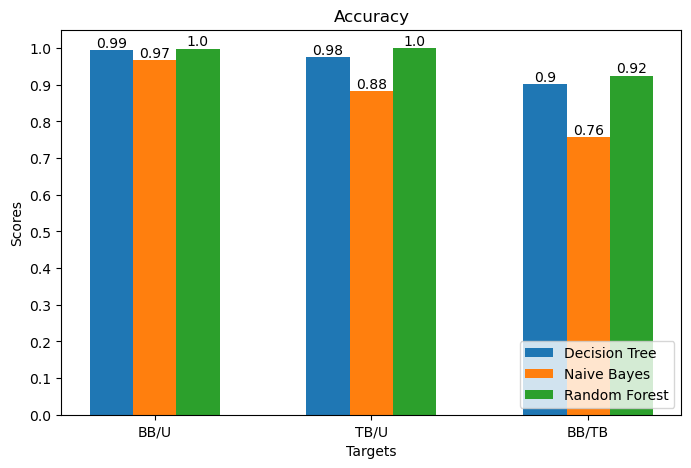

In [55]:

# Inisialisasi list untuk menyimpan nilai akurasi, presisi, recall, dan F1-score
DT_accuracy = []
NB_accuracy = []
RF_accuracy = []

# Iterasi melalui setiap variabel target
for i in range(len(targets)):
    # Hitung nilai-nilai metrik untuk variabel target ke-i
    DT_accuracy.append(accuracy_score(arr_y_test[i, :], DT_ypred[i,:]))
    NB_accuracy.append(accuracy_score(arr_y_test[i, :], NB_ypred[i,:]))
    RF_accuracy.append(accuracy_score(arr_y_test[i, :], RF_ypred[i,:]))

# Membuat plot
x = np.arange(len(targets))

plt.figure(figsize=(8, 5))
bars1 = plt.bar(x - 0.2, DT_accuracy, 0.2, label='Decision Tree')
bars2 = plt.bar(x, NB_accuracy, 0.2, label='Naive Bayes')
bars3 = plt.bar(x + 0.2, RF_accuracy, 0.2, label='Random Forest')
# bars4 = plt.bar(x + 0.4, f1_scores, 0.2, label='F1-score')

plt.xlabel('Targets')
plt.ylabel('Scores')
plt.title('Accuracy')
plt.xticks(x, targets)
plt.yticks(np.arange(0, 1.1, 0.1))  # Atur label pada sumbu y

# Tambahkan nilai di atas setiap bar
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, round(height, 2), ha='center', va='bottom')

plt.legend(loc='lower right')  # Mengatur lokasi legend ke pojok kanan bawah
plt.show()

## Precision

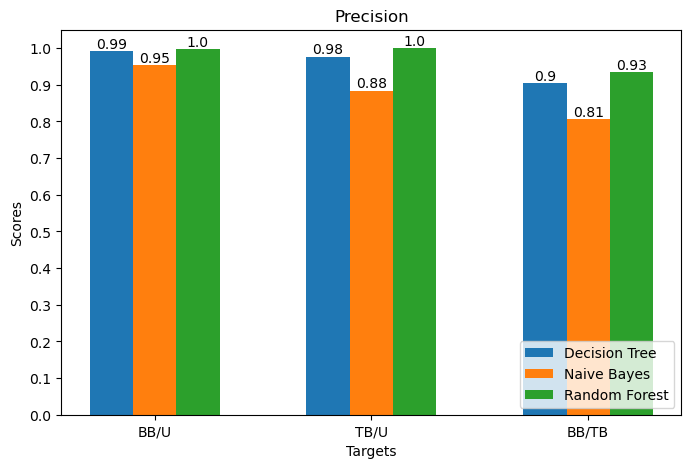

In [56]:

# Inisialisasi list untuk menyimpan nilai akurasi, presisi, recall, dan F1-score
DT_prec = []
NB_prec = []
RF_prec = []

# Iterasi melalui setiap variabel target
for i in range(len(targets)):
    # Hitung nilai-nilai metrik untuk variabel target ke-i
    DT_prec.append(precision_score(arr_y_test[i, :], DT_ypred[i,:], average='macro'))
    NB_prec.append(precision_score(arr_y_test[i, :], NB_ypred[i,:], average='macro'))
    RF_prec.append(precision_score(arr_y_test[i, :], RF_ypred[i,:], average='macro'))

# Membuat plot
x = np.arange(len(targets))

plt.figure(figsize=(8, 5))
bars1 = plt.bar(x - 0.2, DT_prec, 0.2, label='Decision Tree')
bars2 = plt.bar(x, NB_prec, 0.2, label='Naive Bayes')
bars3 = plt.bar(x + 0.2, RF_prec, 0.2, label='Random Forest')
# bars4 = plt.bar(x + 0.4, f1_scores, 0.2, label='F1-score')

plt.xlabel('Targets')
plt.ylabel('Scores')
plt.title('Precision')
plt.xticks(x, targets)
plt.yticks(np.arange(0, 1.1, 0.1))  # Atur label pada sumbu y

# Tambahkan nilai di atas setiap bar
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, round(height, 2), ha='center', va='bottom')

plt.legend(loc='lower right')  # Mengatur lokasi legend ke pojok kanan bawah
plt.show()

## Recall

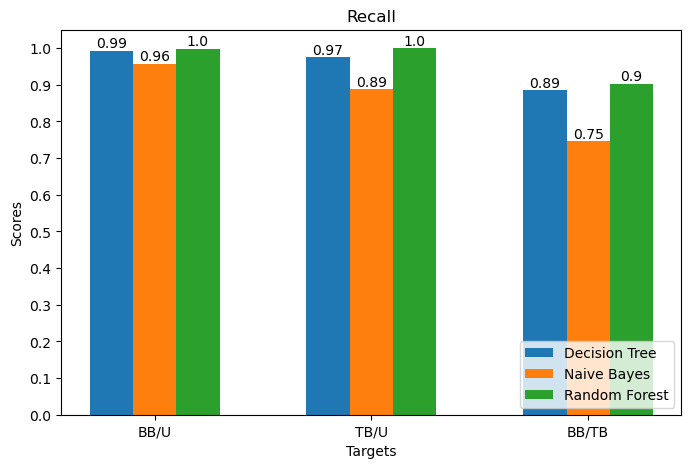

In [57]:

# Inisialisasi list untuk menyimpan nilai akurasi, presisi, recall, dan F1-score
DT_rec = []
NB_rec = []
RF_rec = []

# Iterasi melalui setiap variabel target
for i in range(len(targets)):
    # Hitung nilai-nilai metrik untuk variabel target ke-i
    DT_rec.append(recall_score(arr_y_test[i, :], DT_ypred[i,:], average='macro'))
    NB_rec.append(recall_score(arr_y_test[i, :], NB_ypred[i,:], average='macro'))
    RF_rec.append(recall_score(arr_y_test[i, :], RF_ypred[i,:], average='macro'))

# Membuat plot
x = np.arange(len(targets))

plt.figure(figsize=(8, 5))
bars1 = plt.bar(x - 0.2, DT_rec, 0.2, label='Decision Tree')
bars2 = plt.bar(x, NB_rec, 0.2, label='Naive Bayes')
bars3 = plt.bar(x + 0.2, RF_rec, 0.2, label='Random Forest')
# bars4 = plt.bar(x + 0.4, f1_scores, 0.2, label='F1-score')

plt.xlabel('Targets')
plt.ylabel('Scores')
plt.title('Recall')
plt.xticks(x, targets)
plt.yticks(np.arange(0, 1.1, 0.1))  # Atur label pada sumbu y

# Tambahkan nilai di atas setiap bar
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, round(height, 2), ha='center', va='bottom')

plt.legend(loc='lower right')  # Mengatur lokasi legend ke pojok kanan bawah
plt.show()

## F1-Score

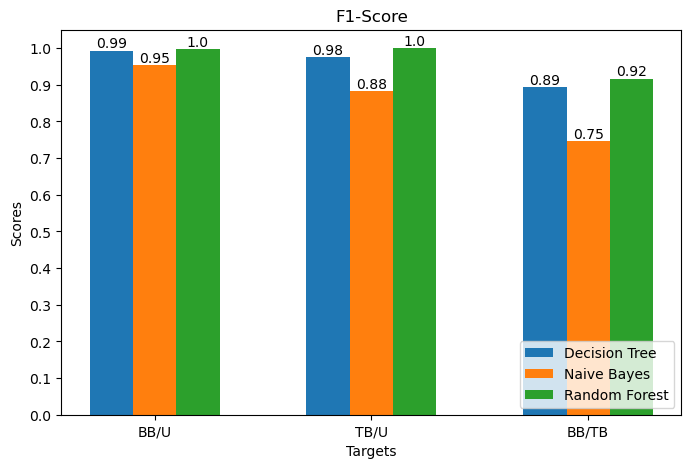

In [58]:

# Inisialisasi list untuk menyimpan nilai akurasi, presisi, recall, dan F1-score
DT_f1score = []
NB_f1score = []
RF_f1score = []

# Iterasi melalui setiap variabel target
for i in range(len(targets)):
    # Hitung nilai-nilai metrik untuk variabel target ke-i
    DT_f1score.append(f1_score(arr_y_test[i, :], DT_ypred[i, :], average='macro'))
    NB_f1score.append(f1_score(arr_y_test[i, :], NB_ypred[i, :], average='macro'))
    RF_f1score.append(f1_score(arr_y_test[i, :], RF_ypred[i, :], average='macro'))
    arr_y_test[i, :], RF_ypred[i,:]

# Membuat plot
x = np.arange(len(targets))

plt.figure(figsize=(8, 5))
bars1 = plt.bar(x - 0.2, DT_f1score, 0.2, label='Decision Tree')
bars2 = plt.bar(x, NB_f1score, 0.2, label='Naive Bayes')
bars3 = plt.bar(x + 0.2, RF_f1score, 0.2, label='Random Forest')
# bars4 = plt.bar(x + 0.4, f1_scores, 0.2, label='F1-score')

plt.xlabel('Targets')
plt.ylabel('Scores')
plt.title('F1-Score')
plt.xticks(x, targets)
plt.yticks(np.arange(0, 1.1, 0.1))  # Atur label pada sumbu y

# Tambahkan nilai di atas setiap bar
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, round(height, 2), ha='center', va='bottom')

plt.legend(loc='lower right')  # Mengatur lokasi legend ke pojok kanan bawah
plt.show()

## AUC-ROC Score

Define the function

In [59]:
def compute_yprobs (model, x_test, y_test):
    y_probs = model.predict_proba(x_test)
    target_binarize = []
    n_classes = []

    for i in range (y_test.T.shape[1]):
        y_test_binarize = label_binarize(y_test[i], classes=np.unique(y_test[i]))
        target_binarize.append(y_test_binarize)
        n_classes.append(y_probs[i].shape[1])

    return target_binarize, n_classes, y_probs

In [60]:
def aucroc_curve(y_binarize, n_classes, y_probs):
    lw = 2
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_binarize[:, i], y_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_binarize.ravel(), y_probs.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at these points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )

    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
        color="navy",
        linestyle=":",
        linewidth=4,
    )

    colors = cycle(["aqua", "darkorange", "cornflowerblue"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=lw,
            label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
        )

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic (ROC) curves")
    plt.legend(loc="lower right")

Result

### Decision Tree

In [61]:
target_binarize, n_classes, y_probs = compute_yprobs(DT_model, X_test, arr_y_test)

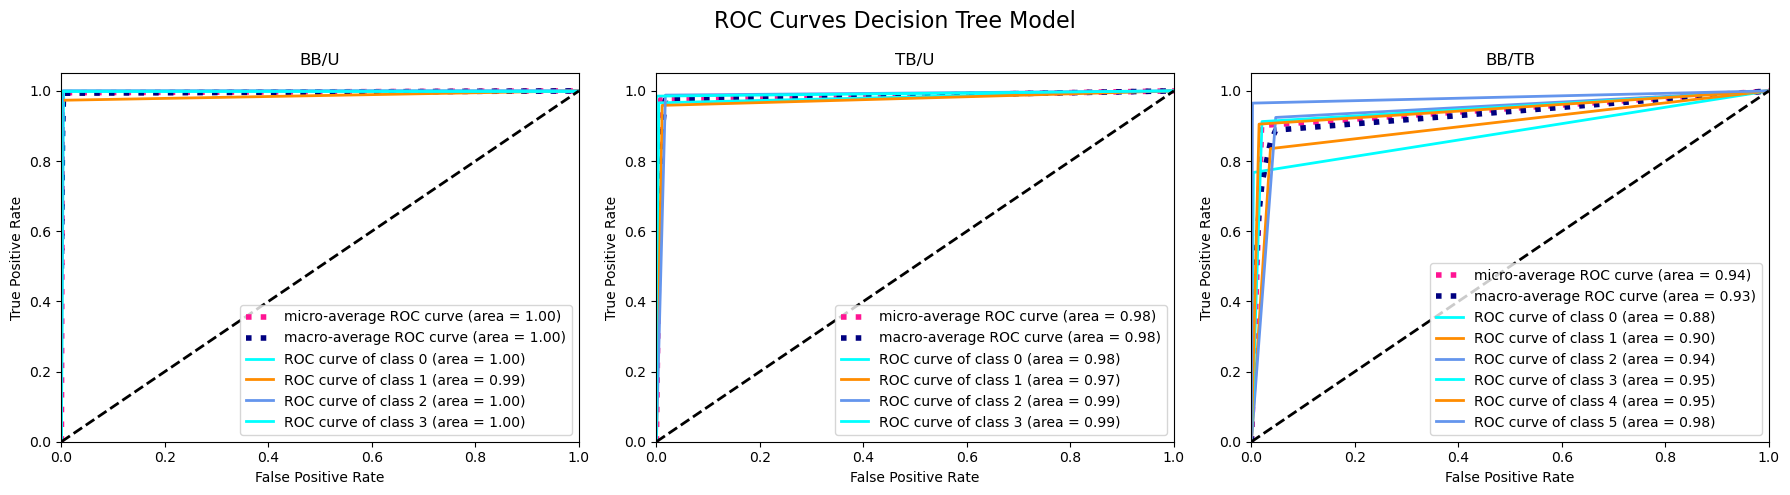

In [62]:
plt.figure(figsize=(18, 5))
plt.suptitle('ROC Curves Decision Tree Model', fontsize=16)  # Judul utama

plt.subplot(1, 3, 1)
aucroc_curve(target_binarize[0], n_classes[0], y_probs[0])
plt.title('BB/U')

plt.subplot(1, 3, 2)
aucroc_curve(target_binarize[1], n_classes[1], y_probs[1])
plt.title('TB/U')

plt.subplot(1, 3, 3)
aucroc_curve(target_binarize[2], n_classes[2], y_probs[2])
plt.title('BB/TB')

plt.tight_layout()
plt.show()

### Naive Bayes

In [63]:
target_binarize, n_classes, y_probs = compute_yprobs(NB_model, X_test, arr_y_test)

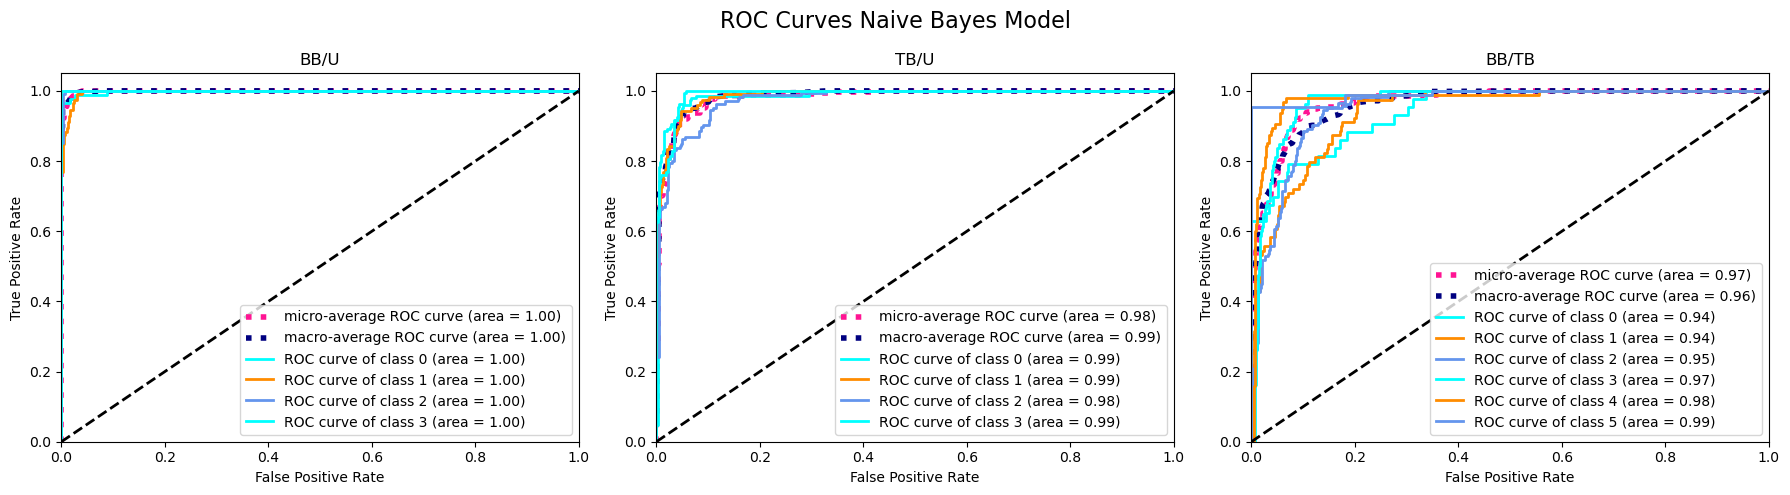

In [64]:
plt.figure(figsize=(18, 5))
plt.suptitle('ROC Curves Naive Bayes Model', fontsize=16)  # Judul utama

plt.subplot(1, 3, 1)
aucroc_curve(target_binarize[0], n_classes[0], y_probs[0])
plt.title('BB/U')

plt.subplot(1, 3, 2)
aucroc_curve(target_binarize[1], n_classes[1], y_probs[1])
plt.title('TB/U')

plt.subplot(1, 3, 3)
aucroc_curve(target_binarize[2], n_classes[2], y_probs[2])
plt.title('BB/TB')

plt.tight_layout()
plt.show()

### Random Forest

In [65]:
target_binarize, n_classes, y_probs = compute_yprobs(RF_model, X_test, arr_y_test)

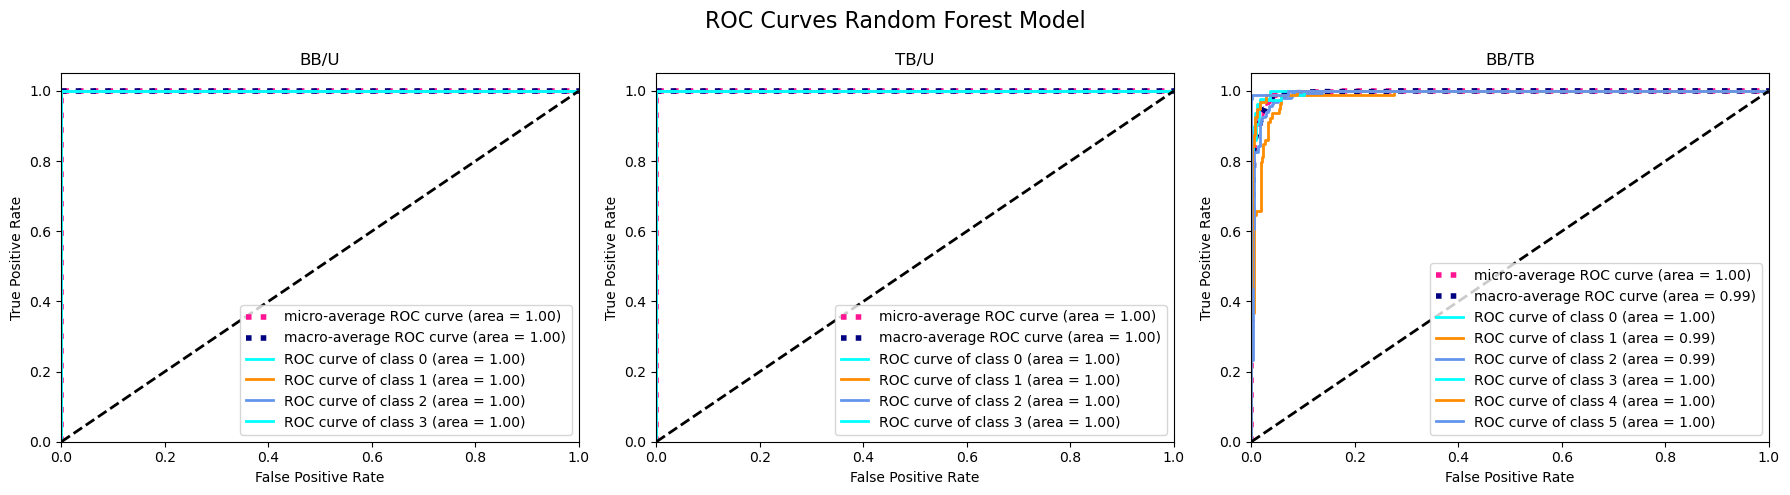

In [66]:
plt.figure(figsize=(18, 5))
plt.suptitle('ROC Curves Random Forest Model', fontsize=16)  # Judul utama

plt.subplot(1, 3, 1)
aucroc_curve(target_binarize[0], n_classes[0], y_probs[0])
plt.title('BB/U')

plt.subplot(1, 3, 2)
aucroc_curve(target_binarize[1], n_classes[1], y_probs[1])
plt.title('TB/U')

plt.subplot(1, 3, 3)
aucroc_curve(target_binarize[2], n_classes[2], y_probs[2])
plt.title('BB/TB')

plt.tight_layout()
plt.show()

# Model Inference

## Menyimpan Model

In [67]:
pickle.dump(DT_model, open('model_dtm.pkl','wb'))
pickle.dump(NB_model, open('model_nbm.pkl','wb'))
pickle.dump(RF_model, open('model_rfm.pkl','wb'))

## Load Model

### Model Path

In [68]:
model_path = ['/home/rmfarizky/Project/deteksi_stunting/Deteksi_Stunting/Classification/model_dtm.pkl',
              '/home/rmfarizky/Project/deteksi_stunting/Deteksi_Stunting/Classification/model_nbm.pkl',
              '/home/rmfarizky/Project/deteksi_stunting/Deteksi_Stunting/Classification/model_rfm.pkl']

### Loading Model

In [69]:
# Load the model
with open(model_path[0], 'rb') as file:
    model_1 = pickle.load(file)

with open(model_path[1], 'rb') as file:
    model_2 = pickle.load(file)
    
with open(model_path[2], 'rb') as file:
    model_3 = pickle.load(file)

In [70]:
df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)
val = df_shuffled.head()
val[:6]

,JK,Usia Saat Ukur,Berat,Tinggi,LiLA,ZS BB/U,ZS TB/U,ZS BB/TB,BB/U,TB/U,BB/TB
0,1,10,9.00,74.00,14.0,-2.52,-0.79,-3.18,1,2,0
1,0,11,6.92,67.63,14.5,-1.93,-2.04,-1.15,2,1,2
2,0,9,5.91,65.29,13.5,-2.78,-2.01,-2.16,1,1,1
3,1,8,11.19,76.84,13.5,2.43,2.82,1.48,3,2,3
4,0,36,10.43,85.37,0.0,-2.40,-2.69,-1.10,1,1,2


In [71]:
val[val.columns[-3:]]

,BB/U,TB/U,BB/TB
0,1,2,0
1,2,1,2
2,1,1,1
3,3,2,3
4,1,1,2


In [72]:
# Data yang diberikan
x_data = val[fitur]
y_data = val[val.columns[-3:]]
# Membuat DataFrame

In [73]:
prediction_dtm = model_1.predict(x_data)
prediction_nbm = model_2.predict(x_data)
prediction_rfm = model_3.predict(x_data)

In [74]:
# Mencetak setiap variabel
print("Prediction DTM:", prediction_dtm)
print("Prediction NBM:", prediction_nbm)
print("Prediction RFM:", prediction_rfm)

Prediction DTM: [[1 2 0]
 [2 1 2]
 [1 2 1]
 [3 2 3]
 [1 1 2]]
Prediction NBM: [[1 2 2]
 [2 1 2]
 [1 1 2]
 [3 3 4]
 [1 1 2]]
Prediction RFM: [[1 2 1]
 [2 1 2]
 [1 1 1]
 [3 2 3]
 [1 1 2]]


# TESTING WITH DATASET

In [75]:
df1 = pd.read_csv("/home/rmfarizky/Project/deteksi_stunting/DRAFT/Dataset/new_draft/final_data.csv")

In [76]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2848 entries, 0 to 2847
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   JK         2848 non-null   int64  
 1   usia ukur  2848 non-null   float64
 2   Berat      2848 non-null   float64
 3   Tinggi     2848 non-null   float64
 4   ZS BB/U    2848 non-null   float64
 5   ZS TB/U    2848 non-null   float64
 6   ZS BB/TB   2848 non-null   float64
 7   BB/U       2848 non-null   int64  
 8   TB/U       2848 non-null   int64  
 9   BB/TB      2848 non-null   int64  
dtypes: float64(6), int64(4)
memory usage: 222.6 KB


In [77]:
df1.rename(columns={'usia ukur': 'Usia Saat Ukur'}, inplace=True)

In [78]:
Xd = df1[fitur]
yd = df1[df.columns[-3:]]

In [79]:
yd

,BB/U,TB/U,BB/TB
0,1,0,3
1,0,0,1
2,0,0,1
3,0,0,1
4,0,0,1
...,...,...,...
2843,3,3,4
2844,3,3,4
2845,3,3,4
2846,3,3,4


In [80]:
predict_dtm = model_1.predict(Xd)
predict_nbm = model_2.predict(Xd)
predict_rfm = model_3.predict(Xd)

In [81]:
# Inisialisasi list untuk menyimpan laporan klasifikasi
reports = []
targets = ['BB/U', 'TB/U', 'BB/TB']

# Iterasi melalui setiap variabel target
for i in range(y_test.shape[1]):
    # Hitung laporan klasifikasi untuk variabel target ke-i
    report = classification_report(np.array(yd).T[i], predict_rfm.T[i])
    # Tambahkan laporan klasifikasi ke dalam list
    reports.append(report)

# Tampilkan laporan klasifikasi untuk setiap variabel target
for i, report in enumerate(reports):
    print(f"Laporan Klasifikasi untuk Target {targets[i]}:")
    print(report)
    print("\n")


Laporan Klasifikasi untuk Target BB/U:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       465
           1       1.00      1.00      1.00       605
           2       1.00      1.00      1.00       508
           3       1.00      1.00      1.00      1270

    accuracy                           1.00      2848
   macro avg       1.00      1.00      1.00      2848
weighted avg       1.00      1.00      1.00      2848



Laporan Klasifikasi untuk Target TB/U:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       777
           1       1.00      1.00      1.00       676
           2       1.00      1.00      1.00       750
           3       1.00      1.00      1.00       645

    accuracy                           1.00      2848
   macro avg       1.00      1.00      1.00      2848
weighted avg       1.00      1.00      1.00      2848



Laporan Klasifikasi untuk Target BB/TB:
        